In [48]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant

In [49]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.array([[1]])
B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.array([[1]])
A2 = np.array([[1]])

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.array([0.8])
R2 = np.array([0.4])

# Initial behavior
behav_1 = np.array([0.2])
behav_2 = np.array([0.3])

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.3])
T2 = np.array([0.3])


# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    if new_state[0] > 1:
        new_state[0]= 0.99
    if new_state[0] < 0:
        new_state[0] = 0.01
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model



# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

# adjusts reference given error
def reference_update_conform(reference, error):
    k = 0.05
    reference = reference - (error * k)
    if reference < 0:
        reference = 0.01
    if reference > 1:
        reference = 0.99
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference


def reference_update_8_6(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, 8, 6)*(reference - error) + (1-shifted_sigmoid(sqr_error, 8, 6))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

conformist = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
        system_estimate=A2, reference=R2, init_behavior=behav_2)

agent_8_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

0
Agent 1
[0.04392432]
Agent 2
[0.01763795]
1
Agent 1
[0.03432104]
Agent 2
[0.01688529]
2
Agent 1
[6.84177649e-16]
Agent 2
[7.38684287e-16]

 Sigmoid Model Agents (Error Relative to Expectation + Preference)
Agent 1 darker and manipulated
Agent 2 is lighter and conforms
blue experiment is sigmoid
green experiment is stubborn
red experiment is conformists
Initial  behavior and reference signals are randomly initialized


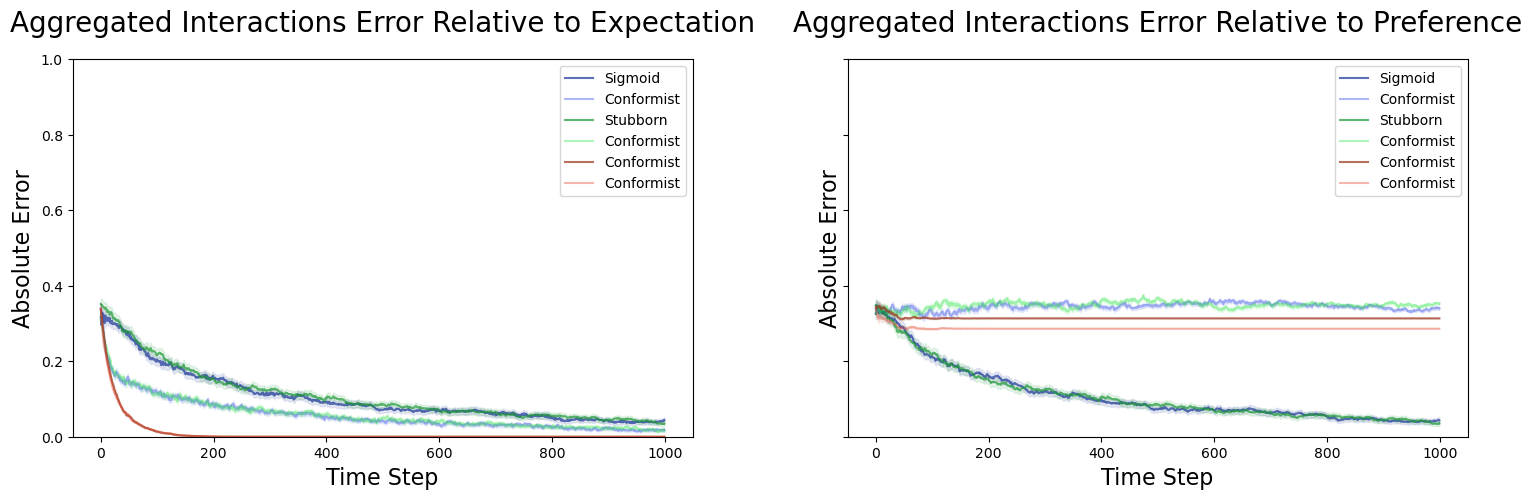

In [50]:
# np.random.seed(31)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, 2, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
experiments = 400
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
labels = ["Sigmoid", "Stubborn", "Conformist"]

for ix, param in enumerate(param_vals):
    agent1_errors = []
    agent2_errors = []
    agent1_pref_errors = []
    agent2_pref_errors = []
    for e in range(experiments):
        # experiments
        behav_1 = np.random.rand(1,1)[0]
        behav_2 = np.random.rand(1,1)[0]
        R1 = np.random.rand(1,1)[0]
        R2 = np.random.rand(1,1)[0]
        b1 = np.random.rand(1,1)[0]
        b2 = np.random.rand(1,1)[0]

        
        plant1 = Plant(transition_matrix=T1, transition_function=transition, state=b1)
        plant2 = Plant(transition_matrix=T2, transition_function=transition, state=b2)

        conformist = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
        system_estimate=A2, reference=R2, init_behavior=b2)

        agent_8_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=b1)

        stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=b1)

        conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=b1)
        
        agents2 = [conformist]
        agents1 = [agent_8_6, stubborn, conformist2]

        agent2 = agents2[0]
        agent1 = agents1[param]
        agent1_error = []
        agent2_error = []
        agent1_pref_error = []
        agent2_pref_error = []
        for t in range(trials):
            #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
            #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
            b1_control = agent1.go(b2)   
            b2_control = agent2.go(b1)

            # agent1_control.append(agent1.get_output())
            # agent2_control.append(agent2.get_output())

            b1 = plant1.transition(b1_control)
            b2 = plant2.transition(b2_control)

            # agent1_behaviors.append(b1)
            # agent2_behaviors.append(b2)

            agent1_error.append(np.absolute(agent1.get_error()))
            agent2_error.append(np.absolute(agent2.get_error()))

            agent1_pref_error.append(np.absolute(R1-b2))
            agent2_pref_error.append(np.absolute(R2-b1))


            # agent1_reference.append(agent1.get_reference()[0])
            # agent2_reference.append(agent2.get_reference()[0])
        # aggregate the errors across experiments
        agent1_errors.append(agent1_error)
        agent2_errors.append(agent2_error)
        agent1_pref_errors.append(agent1_pref_error)
        agent2_pref_errors.append(agent2_pref_error)

    error1_mat = np.array(agent1_errors)
    error2_mat = np.array(agent2_errors)
    pref_error1_mat = np.array(agent1_pref_errors)
    pref_error2_mat = np.array(agent2_pref_errors)

    mean_error1 = np.average(error1_mat, axis=0)
    mean_error2 = np.average(error2_mat, axis=0)
    mean_pref_error1 = np.average(pref_error1_mat, axis=0)
    mean_pref_error2 = np.average(pref_error2_mat, axis=0)

    print(param)
    print("Agent 1")
    print(mean_error1[-1])
    print("Agent 2")
    print(mean_error2[-1])
    
    std_error1  = error1_mat.std(0)
    std_error2  = error2_mat.std(0)
    std_pref_error1  = pref_error1_mat.std(0)
    std_pref_error2  = pref_error2_mat.std(0)
    t = [n for n in range(trials)]
    ci1 = 1.96 * std_error1/np.sqrt(trials)
    ci2 = 1.96 * std_error2/np.sqrt(trials)
    pref_ci1 = 1.96 * std_pref_error1/np.sqrt(trials)
    pref_ci2 = 1.96 * std_pref_error2/np.sqrt(trials)

    upper1 = mean_error1+ci1
    lower1 = mean_error1-ci1
    pref_upper1 = mean_pref_error1+ci1
    pref_lower1 = mean_pref_error1-ci1
    upper1 = upper1.reshape(trials,)
    lower1 = lower1.reshape(trials,)
    pref_upper1 = pref_upper1.reshape(trials,)
    pref_lower1 = pref_lower1.reshape(trials,)
    upper2 = mean_error2+ci2
    lower2 = mean_error2-ci2
    pref_upper2 = mean_pref_error2+ci2
    pref_lower2 = mean_pref_error2-ci2
    upper2 = upper2.reshape(trials,)
    lower2 = lower2.reshape(trials,)
    pref_upper2 = pref_upper2.reshape(trials,)
    pref_lower2 = pref_lower2.reshape(trials,)
    # fig, ax = plt.subplots()
    # ax.plot(t,mean_error1, 'b',label="Agent 1")
    # ax.plot(t,mean_error2, 'g', label="Agent 2")
    # ax.fill_between(t, lower1, upper1, color='b', alpha=.1)
    # ax.fill_between(t, lower2, upper2, color='g', alpha=.1)

    # ai = tups[ix]
    
    # plots
    color = colors[param]
    color_c = colors_c[param]
    ax[0].plot(time, mean_error1, color=color,label=labels[param])
    ax[0].plot(time, mean_error2, color=color_c, label=labels[-1])
    ax[1].plot(time, mean_pref_error1, color=color,label=labels[param])
    ax[1].plot(time, mean_pref_error2, color=color_c, label=labels[-1])
    ax[0].fill_between(t, lower1, upper1, color=color, alpha=.1)
    ax[0].fill_between(t, lower2, upper2, color=color_c, alpha=.1)
    ax[1].fill_between(t, pref_lower1, pref_upper1, color=color, alpha=.1)
    ax[1].fill_between(t, pref_lower2, pref_upper2, color=color_c, alpha=.1)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("Error Relative to Expectation")
    ax[1].set_xlabel("Error Relative to Preference")
    ax[0].set_ylabel("Time Steps")
    ax[1].set_ylabel("Time Steps")
    # ax[ai].set_title('A1 =, A1 b = {}, A2 = conformist'.format(agents_k[param], agents_b[param]))
    ax[0].set_title("Aggregated Interactions Error Relative to Expectation", fontsize=20, pad=20)
    ax[1].set_title("Aggregated Interactions Error Relative to Preference", fontsize=20, pad=20)
    # ax[ai].set_xlim(0,t)
    ax[0].set_ylim(0,1)
    ax[1].set_ylim(0,1)
    ax[0].tick_params(axis='x')
    ax[0].tick_params(axis='y')
    ax[1].tick_params(axis='x')
    ax[1].tick_params(axis='y')
    ax[0].set_xlabel("Time Step", fontsize=16)
    ax[0].set_ylabel("Absolute Error", fontsize=16)
    ax[1].set_xlabel("Time Step", fontsize=16)
    ax[1].set_ylabel("Absolute Error", fontsize=16)

print("\n Sigmoid Model Agents (Error Relative to Expectation + Preference)")
print("Agent 1 darker and manipulated")
print("Agent 2 is lighter and conforms")
print("blue experiment is sigmoid")
print("green experiment is stubborn")
print("red experiment is conformists")
print("Initial  behavior and reference signals are randomly initialized")
plt.show()

### Unbounded Behavior

In [57]:
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.array([[1]])
B2 = np.array([[1]])

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.array([[1]])
A2 = np.array([[1]])

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.array([0.8])
R2 = np.array([0.4])

# Initial behavior
behav_1 = np.array([0.2])
behav_2 = np.array([0.3])

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.3])
T2 = np.array([0.3])


# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    # if new_state[0] > 1:
    #     new_state[0]= 0.99
    # if new_state[0] < 0:
    #     new_state[0] = 0.01
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model



# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

# adjusts reference given error
def reference_update_conform(reference, error):
    k = 0.05
    reference = reference - (error * k)
    # if reference < 0:
    #     reference = 0.01
    # if reference > 1:
    #     reference = 0.99
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference


def reference_update_8_6(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, 0.5, 2)*(reference - error) + (1-shifted_sigmoid(sqr_error, 0.5, 2))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

conformist = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
        system_estimate=A2, reference=R2, init_behavior=behav_2)

agent_8_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

0
Agent 1
[0.84696582]
Agent 2
[1.07199183]
1
Agent 1
[6707.32380376]
Agent 2
[3306.01945351]
2
Agent 1
[1.05822631e-15]
Agent 2
[1.09291943e-15]

 Sigmoid Model Agents (Error Relative to Expectation + Preference)
Agent 1 darker and manipulated
Agent 2 is lighter and conforms
blue experiment is sigmoid
green experiment is stubborn
red experiment is conformists
Initial  behavior and reference signals are randomly initialized


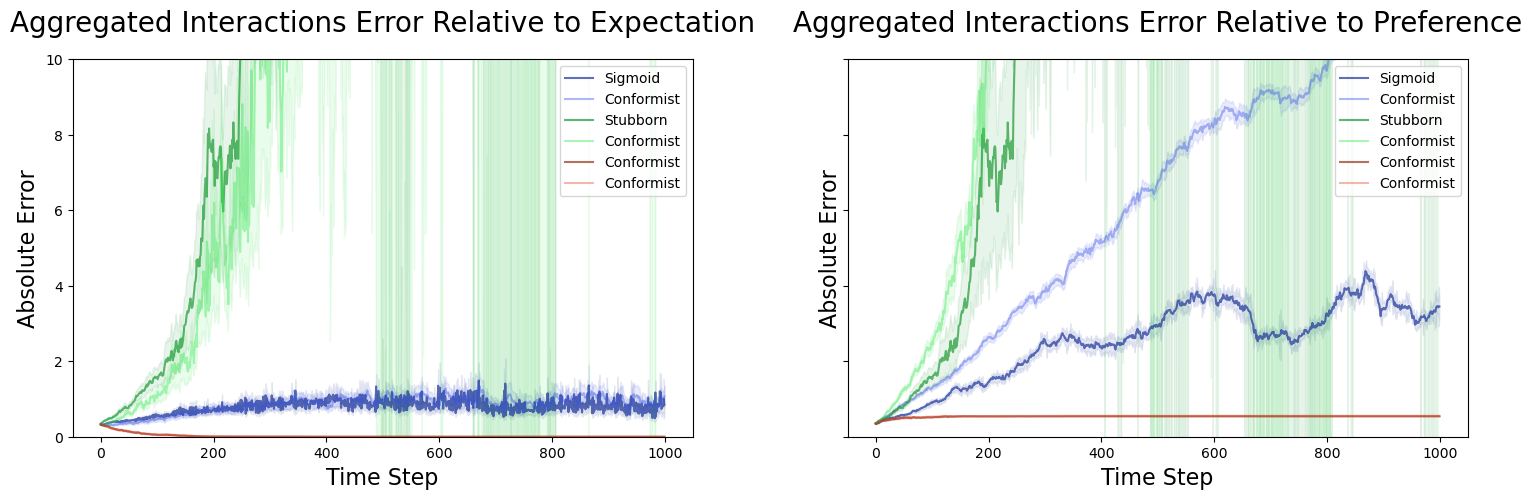

In [58]:
# np.random.seed(31)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, 2, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
experiments = 400
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
labels = ["Sigmoid", "Stubborn", "Conformist"]

for ix, param in enumerate(param_vals):
    agent1_errors = []
    agent2_errors = []
    agent1_pref_errors = []
    agent2_pref_errors = []
    for e in range(experiments):
        # experiments
        behav_1 = np.random.rand(1,1)[0]
        behav_2 = np.random.rand(1,1)[0]
        R1 = np.random.rand(1,1)[0]
        R2 = np.random.rand(1,1)[0]
        b1 = np.random.rand(1,1)[0]
        b2 = np.random.rand(1,1)[0]

        
        plant1 = Plant(transition_matrix=T1, transition_function=transition, state=b1)
        plant2 = Plant(transition_matrix=T2, transition_function=transition, state=b2)

        conformist = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
        system_estimate=A2, reference=R2, init_behavior=b2)

        agent_8_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=b1)

        stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=b1)

        conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_conform,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=b1)
        
        agents2 = [conformist]
        agents1 = [agent_8_6, stubborn, conformist2]

        agent2 = agents2[0]
        agent1 = agents1[param]
        agent1_error = []
        agent2_error = []
        agent1_pref_error = []
        agent2_pref_error = []
        for t in range(trials):
            #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
            #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
            b1_control = agent1.go(b2)   
            b2_control = agent2.go(b1)

            # agent1_control.append(agent1.get_output())
            # agent2_control.append(agent2.get_output())

            b1 = plant1.transition(b1_control)
            b2 = plant2.transition(b2_control)

            # agent1_behaviors.append(b1)
            # agent2_behaviors.append(b2)

            agent1_error.append(np.absolute(agent1.get_error()))
            agent2_error.append(np.absolute(agent2.get_error()))

            agent1_pref_error.append(np.absolute(R1-b2))
            agent2_pref_error.append(np.absolute(R2-b1))


            # agent1_reference.append(agent1.get_reference()[0])
            # agent2_reference.append(agent2.get_reference()[0])
        # aggregate the errors across experiments
        agent1_errors.append(agent1_error)
        agent2_errors.append(agent2_error)
        agent1_pref_errors.append(agent1_pref_error)
        agent2_pref_errors.append(agent2_pref_error)

    error1_mat = np.array(agent1_errors)
    error2_mat = np.array(agent2_errors)
    pref_error1_mat = np.array(agent1_pref_errors)
    pref_error2_mat = np.array(agent2_pref_errors)

    mean_error1 = np.average(error1_mat, axis=0)
    mean_error2 = np.average(error2_mat, axis=0)
    mean_pref_error1 = np.average(pref_error1_mat, axis=0)
    mean_pref_error2 = np.average(pref_error2_mat, axis=0)

    print(param)
    print("Agent 1")
    print(mean_error1[-1])
    print("Agent 2")
    print(mean_error2[-1])
    
    std_error1  = error1_mat.std(0)
    std_error2  = error2_mat.std(0)
    std_pref_error1  = pref_error1_mat.std(0)
    std_pref_error2  = pref_error2_mat.std(0)
    t = [n for n in range(trials)]
    ci1 = 1.96 * std_error1/np.sqrt(trials)
    ci2 = 1.96 * std_error2/np.sqrt(trials)
    pref_ci1 = 1.96 * std_pref_error1/np.sqrt(trials)
    pref_ci2 = 1.96 * std_pref_error2/np.sqrt(trials)

    upper1 = mean_error1+ci1
    lower1 = mean_error1-ci1
    pref_upper1 = mean_pref_error1+ci1
    pref_lower1 = mean_pref_error1-ci1
    upper1 = upper1.reshape(trials,)
    lower1 = lower1.reshape(trials,)
    pref_upper1 = pref_upper1.reshape(trials,)
    pref_lower1 = pref_lower1.reshape(trials,)
    upper2 = mean_error2+ci2
    lower2 = mean_error2-ci2
    pref_upper2 = mean_pref_error2+ci2
    pref_lower2 = mean_pref_error2-ci2
    upper2 = upper2.reshape(trials,)
    lower2 = lower2.reshape(trials,)
    pref_upper2 = pref_upper2.reshape(trials,)
    pref_lower2 = pref_lower2.reshape(trials,)
    # fig, ax = plt.subplots()
    # ax.plot(t,mean_error1, 'b',label="Agent 1")
    # ax.plot(t,mean_error2, 'g', label="Agent 2")
    # ax.fill_between(t, lower1, upper1, color='b', alpha=.1)
    # ax.fill_between(t, lower2, upper2, color='g', alpha=.1)

    # ai = tups[ix]
    
    # plots
    color = colors[param]
    color_c = colors_c[param]
    ax[0].plot(time, mean_error1, color=color,label=labels[param])
    ax[0].plot(time, mean_error2, color=color_c, label=labels[-1])
    ax[1].plot(time, mean_pref_error1, color=color,label=labels[param])
    ax[1].plot(time, mean_pref_error2, color=color_c, label=labels[-1])
    ax[0].fill_between(t, lower1, upper1, color=color, alpha=.1)
    ax[0].fill_between(t, lower2, upper2, color=color_c, alpha=.1)
    ax[1].fill_between(t, pref_lower1, pref_upper1, color=color, alpha=.1)
    ax[1].fill_between(t, pref_lower2, pref_upper2, color=color_c, alpha=.1)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("Error Relative to Expectation")
    ax[1].set_xlabel("Error Relative to Preference")
    ax[0].set_ylabel("Time Steps")
    ax[1].set_ylabel("Time Steps")
    # ax[ai].set_title('A1 =, A1 b = {}, A2 = conformist'.format(agents_k[param], agents_b[param]))
    ax[0].set_title("Aggregated Interactions Error Relative to Expectation", fontsize=20, pad=20)
    ax[1].set_title("Aggregated Interactions Error Relative to Preference", fontsize=20, pad=20)
    # ax[ai].set_xlim(0,t)
    ax[0].set_ylim(0,10)
    ax[1].set_ylim(0,10)
    ax[0].tick_params(axis='x')
    ax[0].tick_params(axis='y')
    ax[1].tick_params(axis='x')
    ax[1].tick_params(axis='y')
    ax[0].set_xlabel("Time Step", fontsize=16)
    ax[0].set_ylabel("Absolute Error", fontsize=16)
    ax[1].set_xlabel("Time Step", fontsize=16)
    ax[1].set_ylabel("Absolute Error", fontsize=16)

print("\n Sigmoid Model Agents (Error Relative to Expectation + Preference)")
print("Agent 1 darker and manipulated")
print("Agent 2 is lighter and conforms")
print("blue experiment is sigmoid")
print("green experiment is stubborn")
print("red experiment is conformists")
print("Initial  behavior and reference signals are randomly initialized")
plt.show()

In [51]:
# np.random.seed(31)
w = 6; h = 5
ncols = 4
nrows = 4
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_k = ['4', '8', '12', '16', '4', '8', '12', '16', '4', '8', '12', '16', '4', '8', '12', '16']
agents_b = ['2', '2', '2', '2', '4', '4', '4', '4', '6', '6',
'6', '6', '8', '8', '8', '8']
agents2 = [conformist]
agents1 = [agent_4_2, agent_8_2, agent_12_2, agent_16_2, agent_4_4, agent_8_4, agent_12_4, agent_16_4, agent_4_6, agent_8_6,
agent_12_6, agent_16_6, agent_4_8, agent_8_8, agent_12_8, agent_16_8]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
experiments = 400
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.8, 0.7]
color2 = [0.1,0.8,0.2, 0.7]


for ix, param in enumerate(param_vals):
    agent1_errors = []
    agent2_errors = []
    for e in range(experiments):
        # experiments
        behav_1 = np.random.rand(1,1)[0]
        behav_2 = np.random.rand(1,1)[0]
        R1 = np.random.rand(1,1)[0]
        R2 = np.random.rand(1,1)[0]
        
        plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)


        conformist = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
        system_estimate=A2, reference=R2, init_behavior=behav_2)

        agent_4_2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_4_2,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_8_2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_2,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_12_2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_12_2,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_16_2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_16_2,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_4_4 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_4_4,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_8_4 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_4,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_12_4 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_12_4,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_16_4 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_16_4,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_4_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_4_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_8_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_12_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_12_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_16_6 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_16_6,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_4_8 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_4_8,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_8_8 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_8_8,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_12_8 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_12_8,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)

        agent_16_8 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_16_8,
        controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
        system_estimate=A1, reference=R1, init_behavior=behav_1)


        plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)


        b1 = np.random.rand(1,1)[0]
        b2 = np.random.rand(1,1)[0]

        agent2 = agents2[0]
        agent1 = agents1[param]
        agent1_error = []
        agent2_error = []
        for t in range(trials):
            #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
            #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
            b1_control = agent1.go(b2)   
            b2_control = agent2.go(b1)

            # agent1_control.append(agent1.get_output())
            # agent2_control.append(agent2.get_output())

            b1 = plant1.transition(b1_control)
            b2 = plant2.transition(b2_control)

            # agent1_behaviors.append(b1)
            # agent2_behaviors.append(b2)

            agent1_error.append(np.absolute(R1-b2))
            agent2_error.append(np.absolute(R2-b1))

            # agent1_reference.append(agent1.get_reference()[0])
            # agent2_reference.append(agent2.get_reference()[0])
        # aggregate the errors across experiments
        agent1_errors.append(agent1_error)
        agent2_errors.append(agent2_error)

    error1_mat = np.array(agent1_errors)
    error2_mat = np.array(agent2_errors)

    mean_error1 = np.average(error1_mat, axis=0)
    mean_error2 = np.average(error2_mat, axis=0)
    
    print(param)
    print("Agent 1")
    print(mean_error1[-1])
    print("Agent 2")
    print(mean_error2[-1])

    std_error1  = error1_mat.std(0)
    std_error2  = error2_mat.std(0)
    t = [n for n in range(trials)]
    ci1 = 1.96 * std_error1/np.sqrt(trials)
    ci2 = 1.96 * std_error2/np.sqrt(trials)

    upper1 = mean_error1+ci1
    lower1 = mean_error1-ci1
    upper1 = upper1.reshape(trials,)
    lower1 = lower1.reshape(trials,)
    upper2 = mean_error2+ci2
    lower2 = mean_error2-ci2
    upper2 = upper2.reshape(trials,)
    lower2 = lower2.reshape(trials,)
    # fig, ax = plt.subplots()
    # ax.plot(t,mean_error1, 'b',label="Agent 1")
    # ax.plot(t,mean_error2, 'g', label="Agent 2")
    # ax.fill_between(t, lower1, upper1, color='b', alpha=.1)
    # ax.fill_between(t, lower2, upper2, color='g', alpha=.1)

    ai = tups[ix]
    
    # plots
    ax[ai].plot(time, mean_error1, 'b',label="Agent 1")
    ax[ai].plot(time, mean_error2, 'g', label="Agent 2")
    ax[ai].fill_between(t, lower1, upper1, color='b', alpha=.1)
    ax[ai].fill_between(t, lower2, upper2, color='g', alpha=.1)
    ax[ai].set_title('A1 k = {}, A1 b = {}, A2 = conformist'.format(agents_k[param], agents_b[param]))
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')

print("\n Sigmoid Model Agents (Error Relative to Base Preferences)")
print("Agent 1 is blue and has a flexible strategy")
print("Agent 2 is green and conforms")
print("Initial  behavior and reference signals are randomly initialized")
print("k influences slope, b influences the infleection point/intercept.")
print("A high k and low b = quick or steep inflection point; takes very little error to start conforming.")
print("A low k and high b = slow or shallow inflection point; takes significant error to trigger conforming.")
plt.show()

NameError: name 'agent_4_2' is not defined